In [1]:
!pip3 install xrpl-py

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

We read in all time series data that has necessary parameters for XRP price on a given day (i.e. some 2015 data does not include volume)

In [33]:
data = pd.read_csv('XRP Historical Data.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/21/2023,0.61374,0.61219,0.61770,0.60623,414.70M,0.25%
1,11/20/2023,0.61219,0.62549,0.62808,0.61014,367.19M,-2.12%
2,11/19/2023,0.62546,0.61061,0.62858,0.60139,291.81M,2.44%
3,11/18/2023,0.61058,0.61324,0.61429,0.59112,230.91M,-0.43%
4,11/17/2023,0.61321,0.61198,0.62400,0.58659,459.82M,0.20%


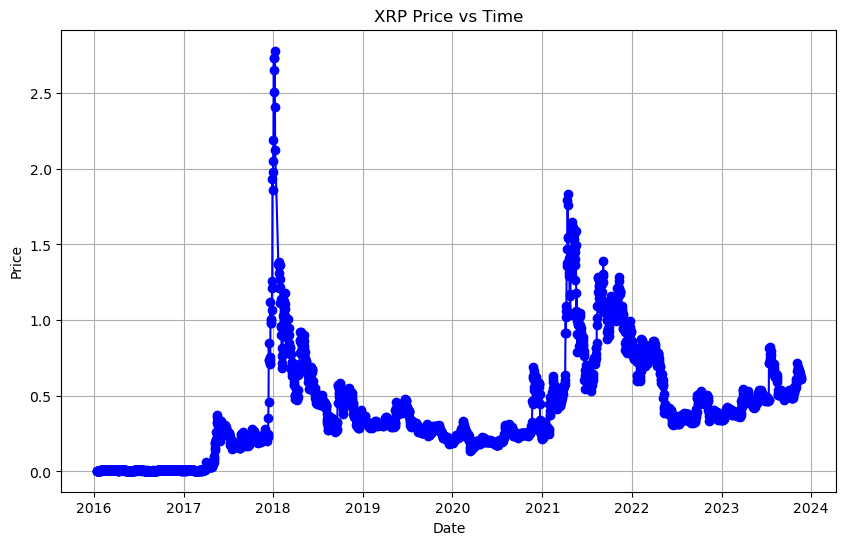

In [71]:
# plot price data over time
dates = data["Date"]
data["Date"] = pd.to_datetime(dates)
data.sort_values(by='Date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Price'], marker='o', linestyle='-', color='b')
plt.title('XRP Price vs Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [35]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
2857,2016-01-13,0.00505,0.00505,0.00505,0.00505,0.20K,0.00%
2856,2016-01-14,0.00479,0.00505,0.00505,0.00401,0.87K,-5.15%
2855,2016-01-15,0.00505,0.00479,0.00505,0.00479,23.97K,5.43%
2854,2016-01-16,0.00489,0.00513,0.00513,0.00465,3.10K,-3.13%
2853,2016-01-17,0.00492,0.00489,0.00492,0.00489,0.64K,0.51%


Now that we've seen what the data looks like, let's conduct some data cleaning so we can use it in our model

In [36]:
# CLEANING DATA 

# def convert_vals_to_int(values):
#     for i in range(len(values)):
#         value = values.iloc[i]
        
#         last_char = value[-1]
#         if last_char == "M":
#             multiplier = 1000000.0
#             item = value[:-1]
#             values.iloc[i] = float(item) * multiplier
#         elif last_char == "B":
#             multiplier = 1000000000.0
#             item = value[:-1]
#             values.iloc[i] = float(item) * multiplier
#         else:
#             multiplier = 1
#             values.iloc[i] = value * multiplier

def convert_vol(value):

    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000.0
    else:
        return float(value)
    

data['Target'] = data['Price'].diff().gt(0).astype(int)





In [37]:

data['Vol.'] = data['Vol.'].apply(convert_vol)
data["Change %"] = data['Change %'].str.replace('%', '').astype(float)

mod_csv = data[["Date", "Price", "Open", "High", "Low", "Vol.", "Change %"]]
mod_csv.to_csv('Modified Data.csv', index=False)


In [38]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Target
2857,2016-01-13,0.00505,0.00505,0.00505,0.00505,200.0,0.00,0
2856,2016-01-14,0.00479,0.00505,0.00505,0.00401,870.0,-5.15,0
2855,2016-01-15,0.00505,0.00479,0.00505,0.00479,23970.0,5.43,1
2854,2016-01-16,0.00489,0.00513,0.00513,0.00465,3100.0,-3.13,0
2853,2016-01-17,0.00492,0.00489,0.00492,0.00489,640.0,0.51,1


First, we'll try a Random Forest Classifier, an ML library that will create decision trees and learn to determine whether XRP price will increase or decrease on a given day

In [42]:

from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-500]
test = data.iloc[-500:]

features = ["Price",  "Open", "High", "Low", "Vol.", "Change %"]
model.fit(train[features], train["Target"])



RandomForestClassifier(min_samples_split=100, random_state=1)

In [43]:
from sklearn.metrics import precision_score

predictions = model.predict(test[features])

predictions = pd.Series(predictions, index = test.index)

predictions


499    0
498    0
497    0
496    1
495    1
      ..
4      1
3      0
2      1
1      0
0      1
Length: 500, dtype: int64

In [44]:
precision_score(test["Target"], predictions) 
precision_percent = precision_score(test["Target"], predictions) * 100.0

print(f"This model predicts when the price will go up or down {precision_percent}% of the time")

This model predicts when the price will go up or down 100.0% of the time


Now that we have gotten a successful prediction of increase or decrease in XRP price, let's try to create a model to predict XRP price. Specifically let's try a recurrent neural network with LSTM and GRU.

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

In [46]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Target
2857,2016-01-13,0.00505,0.00505,0.00505,0.00505,200.0,0.00,0
2856,2016-01-14,0.00479,0.00505,0.00505,0.00401,870.0,-5.15,0
2855,2016-01-15,0.00505,0.00479,0.00505,0.00479,23970.0,5.43,1
2854,2016-01-16,0.00489,0.00513,0.00513,0.00465,3100.0,-3.13,0
2853,2016-01-17,0.00492,0.00489,0.00492,0.00489,640.0,0.51,1


In [52]:

features = data[['Open', 'High', 'Low', 'Vol.', 'Change %', 'Target']]

target = data['Price']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

sequence_length = 10
X, y = [], []

for i in range(len(features_scaled) - sequence_length):
    X.append(features_scaled[i:i+sequence_length, :])
    y.append(target.iloc[i+sequence_length])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
print(f'Mean Squared Error: {mse}')


Epoch 1/10
72/72 [==============================] - 1s 4ms/step - loss: 0.0509 - val_loss: 0.0063
Epoch 2/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0049
Epoch 3/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 4/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 5/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 6/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 7/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 8/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 9/10
72/72 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 10/10
18/18 [==============================] - 0s 785us/step
Mean Squared Error: 0.0019622178401327885


Now that we've trained our model, let's see how it inferences, test its accuracy, and visualize

In [72]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, preds)
print(f'LSTM Model accuracy: {r2*100}%')


LSTM Model accuracy: 98.1854263924939%


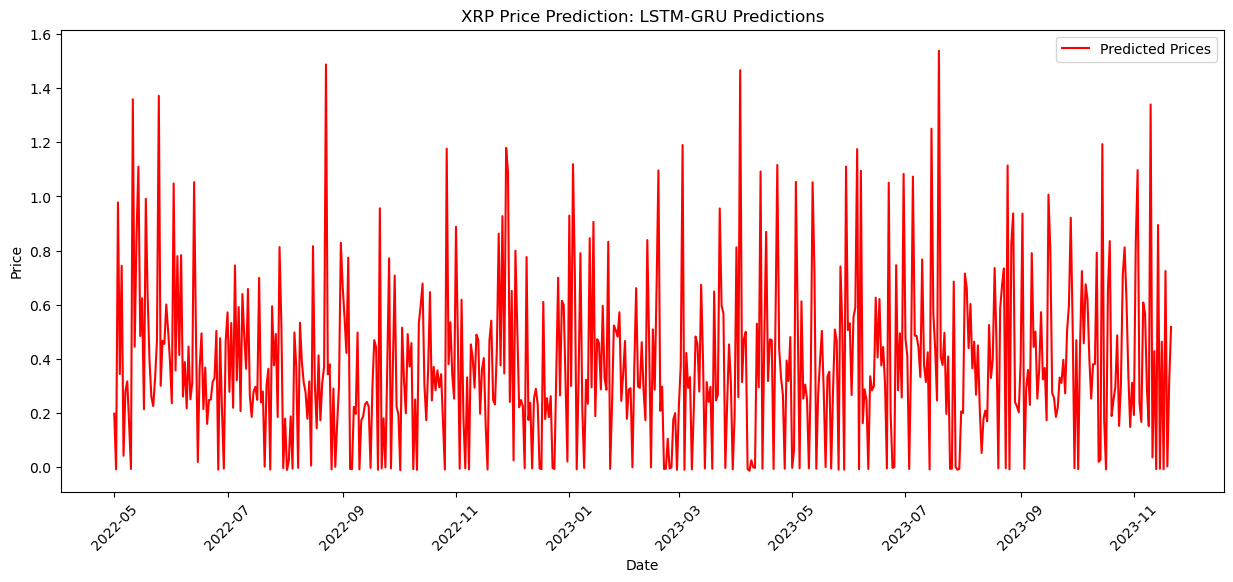

In [70]:

plt.figure(figsize=(15, 6))

plt.plot(dates, preds, label='Predicted Prices', color='red')

plt.title('XRP Price Prediction: LSTM-GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

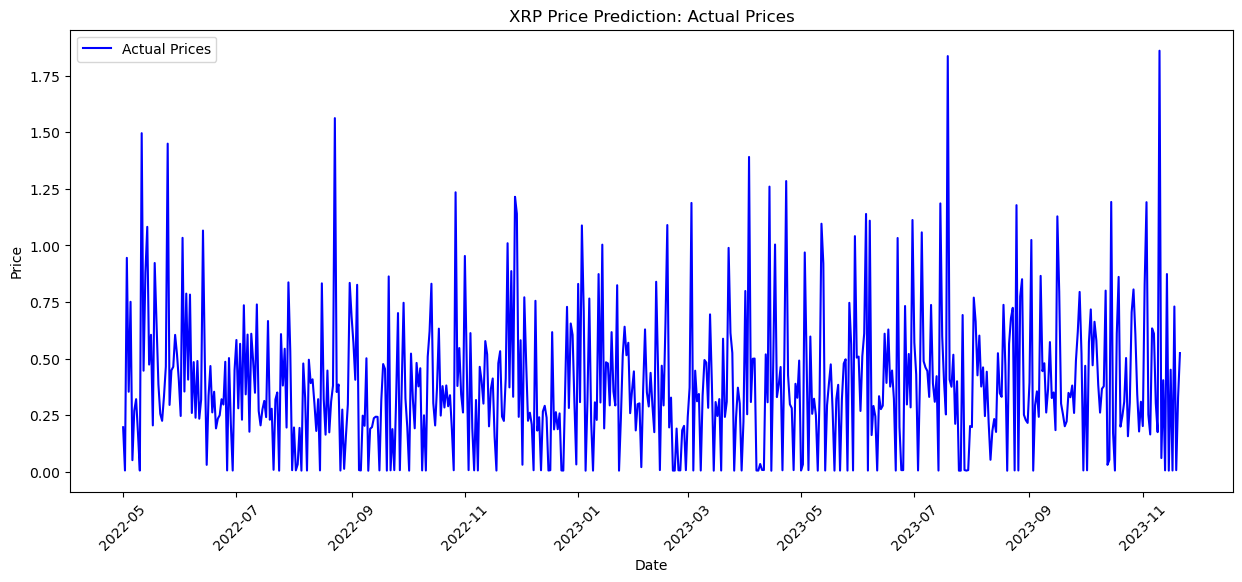

In [68]:
plt.figure(figsize=(15, 6))
plt.plot(dates, y_test, label='Actual Prices', color='blue')

plt.title('XRP Price Prediction: Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45) 
plt.show()

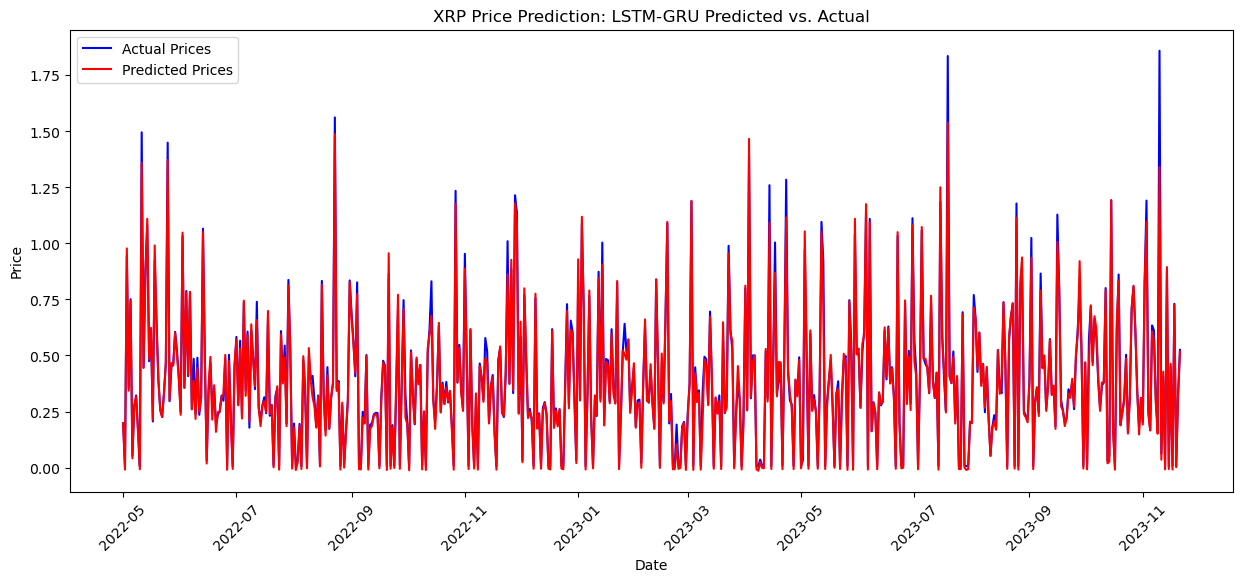

In [69]:

dates = data['Date'].iloc[-len(y_test):] 

plt.figure(figsize=(15, 6))
plt.plot(dates, y_test, label='Actual Prices', color='blue')
plt.plot(dates, preds, label='Predicted Prices', color='red')

plt.title('XRP Price Prediction: LSTM-GRU Predicted vs. Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  
plt.show()


It seems we have pretty accurate inference, and it's seen in the visualizations. For future steps, I would like to use the target values and the pricing predictions in fourier transforms to see if we can get any insight on how to purchase XRP, as numpy makes FFTs really simple to use.